In [1]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Read the CSV file
hsg = pd.read_csv(r'C:\Documents\PTTK\Project\HSG Historical Data.csv')

hsg = hsg.sort_index(ascending=False)
hsg = hsg.reset_index(drop=True)
hsg['Date'] = pd.to_datetime(hsg['Date'])
hsg.set_index('Date', inplace=True)

# Modify data
# Remove the '%' sign and convert to float
hsg['Change %'] = hsg['Change %'].replace('%', '', regex=True).astype(float)

# Convert the percentage values to decimals (divide by 100)
hsg['Change %'] = hsg['Change %'] / 100

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    hsg[col] = hsg[col].str.replace(',', '').astype(float)

missing_values = hsg.isnull().sum()
hsg = hsg.dropna()

# Function to convert 'K' values to integers
def convert_volume(value):
    if pd.isnull(value):
        return np.nan  # Handle missing values
    elif 'K' in value:
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    elif 'B' in value:
        return float(value.replace('B', '')) * 1000000000
    else:
        return float(value)

# Apply the function to the "Volume" column
hsg['Vol.'] = hsg['Vol.'].apply(convert_volume)

# Display the cleaned DataFrame
data = hsg[['Price']]
data

,Price
Date,
2020-01-02,5909.1
2020-01-03,5757.6
2020-01-06,5786.4
2020-01-07,5721.5
2020-01-08,5678.2
...,...
2024-10-28,20750.0
2024-10-29,20700.0
2024-10-30,20350.0


In [5]:
train_size = round(len(data) * 0.7)
test_size = round(len(data) - train_size) 

len(data), train_size, test_size

(1207, 845, 362)

In [6]:
train_data = data[:train_size]
test_data = data[train_size:]

train_data.shape, test_data.shape

((845, 1), (362, 1))

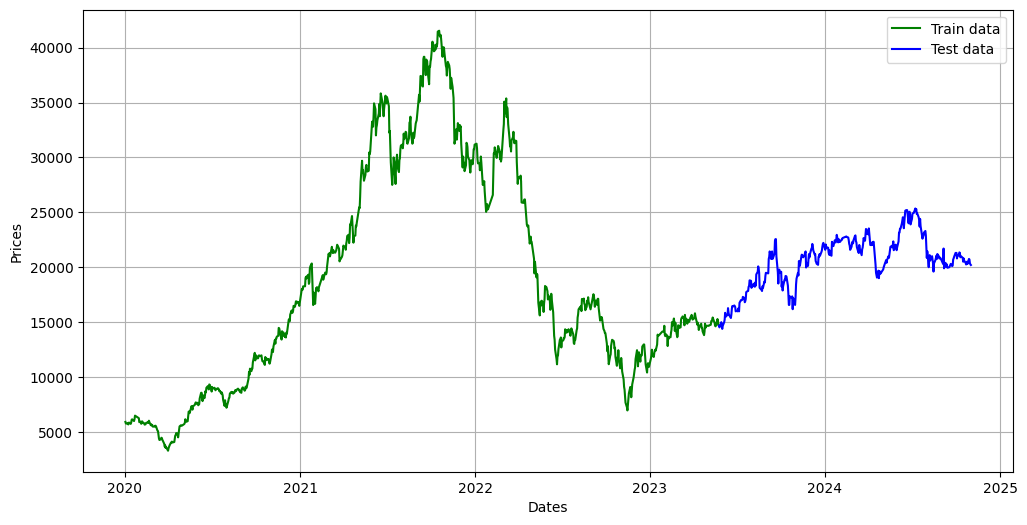

In [7]:
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Price'], 'green', label='Train data')
plt.plot(test_data['Price'], 'blue', label='Test data')
plt.legend()

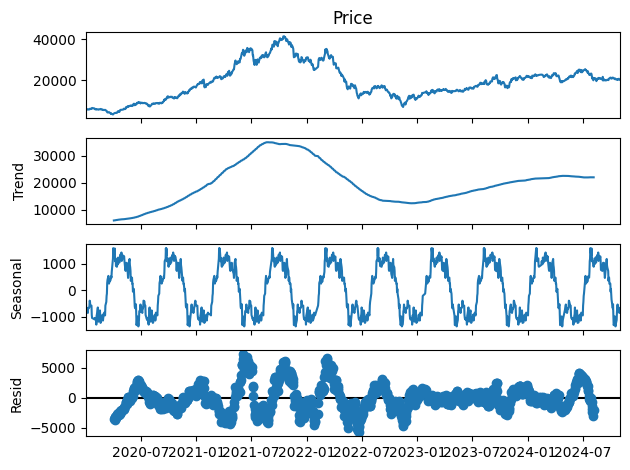

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform seasonal decomposition
result = seasonal_decompose(data['Price'], model='additive', period=120).plot();

In [9]:
model = ExponentialSmoothing(np.asarray(train_data['Price']), trend='add', seasonal='add', seasonal_periods=120).fit()

c:\Users\hien0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [10]:
test_data['Price Predicted'] = model.forecast(len(test_data))

C:\Users\hien0\AppData\Local\Temp\ipykernel_1884\2474305646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Price Predicted'] = model.forecast(len(test_data))


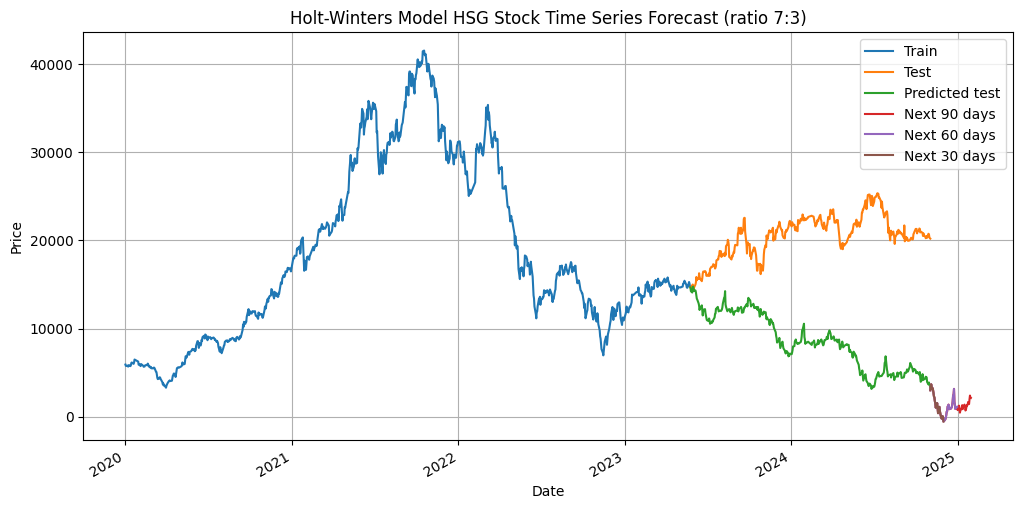

In [12]:
train_data['Price'].plot(legend=True, label='Train', figsize=(12,6))
test_data['Price'].plot(legend=True, label='Test')
test_data['Price Predicted'].plot(legend=True, label='Predicted test')

# Predict prices for the next 30 days
# Generate a range of dates for the next 30 days
next_30_days = pd.date_range(start=test_data.index[-1], periods=30)

# Predict the closing prices for the next 30 days
y_next_30_days = model.forecast(len(next_30_days) + len(test_data))[-30:]

# Predict prices for the next 60 days
next_60_days = pd.date_range(start=test_data.index[-1], periods=60)
y_next_60_days = model.forecast(len(next_60_days) + len(test_data))[-60:]

# Predict prices for the next 90 days
next_90_days = pd.date_range(start=test_data.index[-1], periods=90)
y_next_90_days = model.forecast(len(next_90_days) + len(test_data))[-90:]

plt.plot(next_90_days, y_next_90_days, label='Next 90 days')
plt.plot(next_60_days, y_next_60_days, label='Next 60 days')
plt.plot(next_30_days, y_next_30_days, label='Next 30 days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Holt-Winters Model HSG Stock Time Series Forecast (ratio 7:3)')
plt.legend()
plt.grid(True)
plt.show()